In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio
from bisect import bisect_left

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors, graph_weight_matrix
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.05e-3

In [2]:
interneuron_blue = 'blue'

In [3]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [4]:

def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [5]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [6]:
def load_exp_data(direc, cut=None, layer_size=10, n_exc=1000, new_cell_idx=1000, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    if reverse:
        file_name_count = reversed(file_name_count)
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            exc_raster = loaded['exc_raster']
            inh_raster = loaded['inh_raster']

            first_spk_times = process_single_activation(loaded['exc_raster'].astype(float), n_exc)

            layers_active = []
            layer_weights = []

            data = {
                'index': i_f,
                'first_spk_times': first_spk_times,
                
                'w_e_e': loaded['w_e_e'][0],
                'w_e_i': loaded['w_e_i'][0],
                'w_i_e': loaded['w_i_e'][0],
                
                'exc_raster': exc_raster,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                
                'prop_speed': loaded['prop_speed'][0],
                'avg_temporal_width': loaded['avg_temporal_width'][0],
                'stable': loaded['stable'][0],
                
                'exc_raster_unperturbed': exc_raster,
            }
            if 'gs' in loaded:
                data['gs'] = loaded['gs']
                
            if 'w_r_e' in loaded:
                data['w_r_e'] = loaded['w_r_e']
                data['w_r_i'] = loaded['w_r_i']
                
            surviving_cell_mask = None
            if 'surviving_cell_mask' in loaded:
                surviving_cell_mask = loaded['surviving_cell_mask'][0, :].astype(bool)
                data['surviving_cell_mask'] = surviving_cell_mask
                
                sorting_order = np.argsort(exc_raster[1, :])
                exc_raster_sorted = exc_raster[:, sorting_order]
                indices = np.arange(len(surviving_cell_mask))[surviving_cell_mask.astype(bool)]
                
                exc_raster_unperturbed = []
                exc_raster_perturbed = []
                
                j = 0
                for idx in np.arange(exc_raster_sorted.shape[1]):
                    if j >= len(indices):
                        exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] < indices[j]:
                        exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] == indices[j]:
                        exc_raster_unperturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
                    elif exc_raster_sorted[1, idx] > indices[j]:
                        j += 1
                
                data['exc_raster_unperturbed'] = np.concatenate(exc_raster_unperturbed, axis=1)
                data['exc_raster_perturbed'] = np.concatenate(exc_raster_perturbed, axis=1)
                
            if 'w_r_e' in loaded:
                w_r_e = data['w_r_e']
                
                w_r_e_e = w_r_e[:n_exc, :n_exc]
                w_r_e_i = w_r_e[n_exc:, :n_exc]
                
                if surviving_cell_mask is not None:
                    w_r_e_e_surviving = w_r_e_e[(surviving_cell_mask & (np.arange(n_exc) < new_cell_idx)).astype(bool), :]
                    summed_incoming_weights_e_e = np.sum(w_r_e_e_surviving[:, surviving_cell_mask], axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i[:, surviving_cell_mask], axis=1)
                else:
                    summed_incoming_weights_e_e = np.sum(w_r_e_e, axis=1)
                    summed_incoming_weights_e_i = np.sum(w_r_e_i, axis=1)
                    
#                 print(np.nonzero(summed_incoming_weights_e_e)[0])
#                 print(np.nonzero(summed_incoming_weights_e_i)[0])
                
                data['mean_incoming_summed_weights_e_e'] = np.mean(summed_incoming_weights_e_e)
                data['std_incoming_summed_weights_e_e'] = np.std(summed_incoming_weights_e_e)
                data['mean_incoming_summed_weights_e_i'] = np.mean(summed_incoming_weights_e_i)
                data['std_incoming_summed_weights_e_i'] = np.std(summed_incoming_weights_e_i)
                
            return data
        yield i_f, lazy_load

In [7]:
def downsample_raster(raster, cell_idxs_to_show):
    j = 0
    if raster.size == 0:
        return np.array([])
    sorted_raster = np.array([y for y in sorted(raster.T, key=lambda x: x[1])]).T
    downsampled = []
    for i in range(sorted_raster.shape[1]):
        while j < len(cell_idxs_to_show) and sorted_raster[1, i] > cell_idxs_to_show[j]:
            j += 1
        if j == len(cell_idxs_to_show):
            break
        if sorted_raster[1, i] == cell_idxs_to_show[j]:
            downsampled.append(sorted_raster[:, i])
    if len(downsampled) > 0:
        return np.stack(downsampled).T
    else:
        return np.array([])

def make_figure_1_sparse(name, cell_range=(0, 900), new_cell_idx=None, per_shown=1., layer_size=10, timepoints=[5, 9, 20], sort_timepoint=300, verify_chain_timepoints=None, color='black', reverse=True):
    n_cells = cell_range[1] - cell_range[0]
    
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
  
    count = 0
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        count += 1
        print(exp_dir_name)
        scale = 1.1
        
        fig = plt.figure(constrained_layout=True, figsize=(5 * len(timepoints) * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=len(timepoints), nrows=3, figure=fig)
        axs = [(fig.add_subplot(gs[:1, i]), fig.add_subplot(gs[1:, i])) for i in range(len(timepoints))]
           
        timepoint_names = [rendition_label(t * 10) for t in timepoints]
        j = len(timepoints) - 1 if reverse else 0
        
        first_first_spk_in_range = None
        last_first_spk_in_range = None
        
        cell_idxs_to_show = None
        cell_idx_names = None
        sorted_order = None

        i = 0
        sort_timepoint_hit = False
        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_cells, new_cell_idx=new_cell_idx, name_frags=[], reverse=reverse):
            if i == sort_timepoint:
                sort_timepoint_hit = True
                
                data = load_data()
                first_spk_times = data['first_spk_times']
                first_spk_times[np.isnan(first_spk_times)] = first_spk_times.max() + np.arange(np.sum(np.isnan(first_spk_times)))
                firing_idxs = np.arange(len(first_spk_times))
                
                cell_idxs_to_show = firing_idxs[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])].astype(int)
                shown_first_spk_times = first_spk_times[np.logical_and(firing_idxs >= cell_range[0], firing_idxs < cell_range[1])]
                
#                 to_show_mask = []
#                 for i_k, k in enumerate(range(0, len(firing_idxs), layer_size)):  
#                     x = np.zeros(layer_size)
#                     if i_k % 4 != 0:
#                         x[:int(per_shown * layer_size)] = 1
#                     np.random.shuffle(x)
#                     x = x[:np.minimum(layer_size, len(firing_idxs) - k)]
#                     to_show_mask.append(x)
#                 to_show_mask = np.concatenate(to_show_mask).astype(bool)
                
#                 cell_idxs_to_show = cell_idxs_to_show[to_show_mask]
#                 shown_first_spk_times = shown_first_spk_times[to_show_mask]
                
                
                cell_idx_to_order_map = np.zeros(np.max(cell_idxs_to_show) + 1).astype(int)
                for idx in range(len(cell_idxs_to_show)):
                    cell_idx_to_order_map[cell_idxs_to_show[idx]] = idx
                
                sorted_order = np.nan * np.ones(len(shown_first_spk_times))
                for idx2, k in enumerate(np.argsort(shown_first_spk_times)):
                    sorted_order[k] = idx2
                sorted_order = sorted_order[cell_idx_to_order_map]
            
            if ((j >= 0 and reverse) or (j < len(timepoints) and not reverse)) and i == timepoints[j]:
                if not sort_timepoint_hit:
                    break
                
                data = load_data() if (i != sort_timepoint) else data
                exc_cells_initially_active = data['exc_raster_unperturbed'][:, data['exc_raster_unperturbed'][1, :] < new_cell_idx]
                exc_cells_newly_active = data['exc_raster_unperturbed'][:, data['exc_raster_unperturbed'][1, :] >= new_cell_idx]
                
                exc_cells_initially_active_downsampled = downsample_raster(exc_cells_initially_active, cell_idxs_to_show)
                exc_cells_newly_active_downsampled = downsample_raster(exc_cells_newly_active, cell_idxs_to_show)
                    
                inh_raster = data['inh_raster']
                first_spk_times = data['first_spk_times']
                
                if len(exc_cells_initially_active_downsampled) == 0:
                    continue

                axs[j][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, sorted_order[exc_cells_initially_active_downsampled[1, :].astype(int)], s=10, c='black', zorder=0, alpha=1, marker='|')
                if exc_cells_newly_active_downsampled.size > 0:
                    axs[j][1].scatter(exc_cells_newly_active_downsampled[0, :] * 1000, sorted_order[exc_cells_newly_active_downsampled[1, :].astype(int)], s=10, c='pink', zorder=0, alpha=1, marker='|')
                    
                    
                if len(inh_raster) > 0:
                    axs[j][0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - n_cells, s=10, c=interneuron_blue, zorder=0, alpha=1, marker='|')
                axs[j][1].set_ylim(0, n_cells)
                axs[j][0].set_ylim(0, 30)
                axs[j][0].set_ylabel('Inhibitory\ncell Index')
                axs[j][1].set_ylabel('Excitatory\ncell Index')
                axs[j][1].set_xlabel('Time (ms)')
                axs[j][0].title.set_text(f'{timepoint_names[j]}')
            
                axs[j][0].spines['bottom'].set_visible(False)
                axs[j][1].spines['top'].set_visible(False)
                axs[j][0].tick_params(bottom=False, labelbottom=False)
                
                for row_idx in range(2):
                    # axs[j][row_idx].set_xlim((first_first_spk_in_range - 0.001) * 1000, (last_first_spk_in_range + 0.001) * 1000)
                    axs[j][row_idx].set_xlim(0.05 * 1000, 0.24 * 1000)
                    set_font_size(axs[j][row_idx], 16)
                    axs[j][row_idx].spines['right'].set_visible(False)
                    axs[j][row_idx].set_ylim(6)
                if reverse:
                    j -= 1
                else:
                    j += 1
        
        fig.tight_layout()  
#         save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.svg')

50_per_silent_no_syn_2022-06-15--17:35--55:5107


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


50_per_silent_no_syn_2022-06-15--17:36--14:2567


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


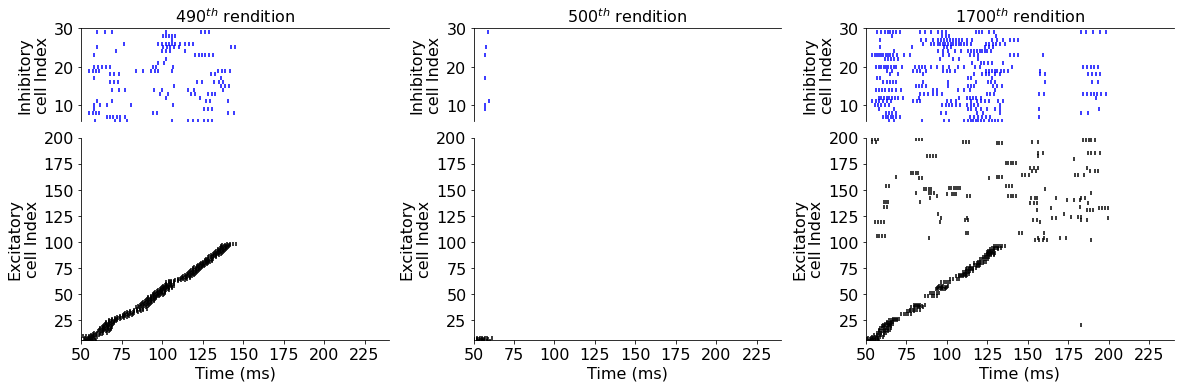

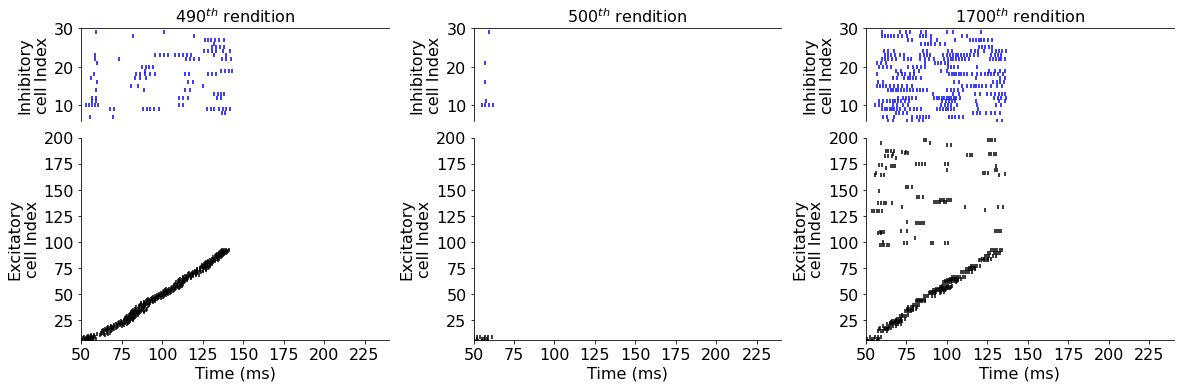

In [10]:
make_figure_1_sparse(
    ['50_per_silent_no_syn'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints=[49, 50, 170],
    sort_timepoint=0,
    per_shown=1.,
    color='#c41f3b',
    reverse=False
)

50_per_silent_no_syn_2022-06-15--17:35--55:5107


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


50_per_silent_no_syn_2022-06-15--17:36--14:2567


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:140: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


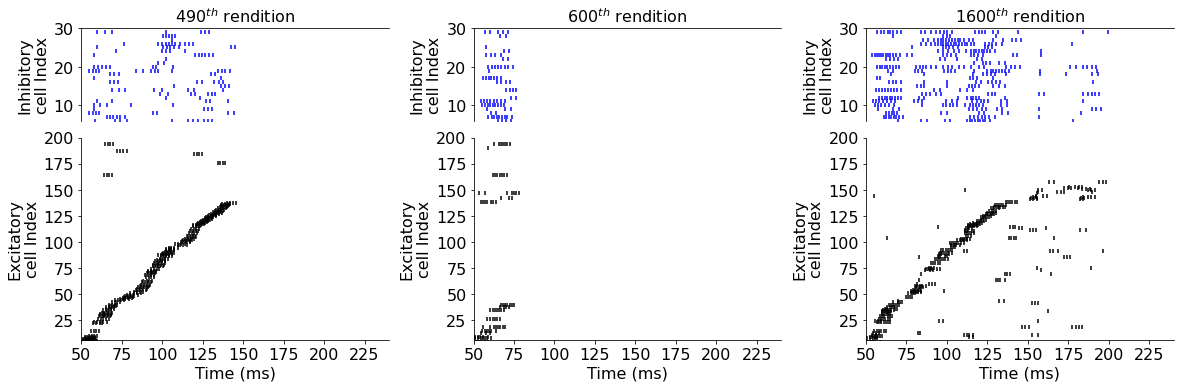

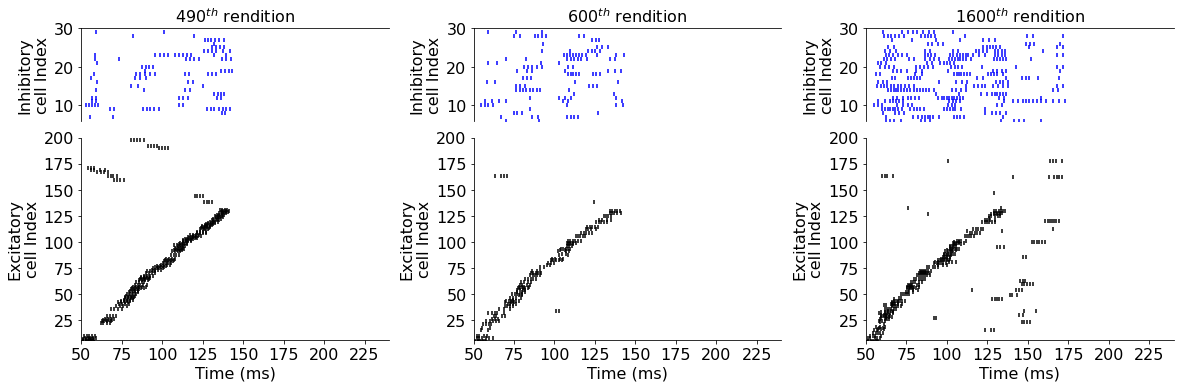

In [20]:
make_figure_1_sparse(
    ['50_per_silent_no_syn'],
    cell_range=(0, 200),
    new_cell_idx=200,
    timepoints=[49, 60, 160],
    sort_timepoint=166,
    per_shown=1.,
    color='#c41f3b',
    reverse=True,
)

In [22]:
def sliding_window_activity(raster, window_size, dt, interval):
    window_size_discrete = int(window_size / dt)
    all_spk_times = np.sort(raster[0, :])
    all_t = np.arange(interval[0], interval[1], dt)
    activity = np.zeros(all_t.shape)
    
    for i_t, t in enumerate(all_t):
        window_start = bisect_left(all_spk_times, t - window_size)
        window_end = bisect_left(all_spk_times, t + window_size)
        activity[i_t] = len(all_spk_times[window_start:window_end])
    return all_t, activity

def make_total_activity_graphs(name, timepoints=[0, 72, 73], n_exc=450, new_cell_idx=None):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        scale = 1.1
        
        fig = plt.figure(constrained_layout=True, figsize=(7 * len(timepoints) * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=len(timepoints) + 2, nrows=2, figure=fig)
        axs = [fig.add_subplot(gs[:, i]) for i in range(len(timepoints) + 2)]
           
        j = len(timepoints) - 1
        
        recovered_total_activity = None
        recovered_old_activity = None

        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), reverse=True, n_exc=n_exc, new_cell_idx=new_cell_idx):
            if j >= 0 and i == timepoints[j]:
                print(j, timepoints[j])
                data = load_data()
                if 'exc_raster_unperturbed' in data:
                    exc_raster = data['exc_raster_unperturbed']
                else:
                    exc_raster = data['exc_raster']
                
                exc_raster_old = exc_raster[:, exc_raster[1, :] < new_cell_idx]
                exc_raster_new = exc_raster[:, exc_raster[1, :] >= new_cell_idx]
                    
                inh_raster = data['inh_raster']
                
                t, e_old_activity_trace = sliding_window_activity(exc_raster_old, 10e-3, dt, (0.05, 0.24))
                t, e_new_activity_trace = sliding_window_activity(exc_raster_new, 10e-3, dt, (0.05, 0.24))
                t, i_activity_trace = sliding_window_activity(inh_raster, 10e-3, dt, (0.05, 0.24))
                
                t = 1000 * t
                
                if j == (len(timepoints) - 1):
                    axs[len(timepoints)].plot(t, e_old_activity_trace + e_new_activity_trace, lw=0.7, c='purple', zorder=0, alpha=1)
                    axs[len(timepoints)].plot(t, e_old_activity_trace, lw=0.7, c='black', zorder=0, alpha=1)
                    recovered_total_activity = e_old_activity_trace + e_new_activity_trace
                    recovered_old_activity = e_old_activity_trace

                if j == 0:
                    axs[len(timepoints)].plot(t, e_old_activity_trace, lw=0.7, c='blue', zorder=0, alpha=1)
                    axs[len(timepoints) + 1].scatter(t, recovered_old_activity / e_old_activity_trace, s=2, c='black', zorder=0, alpha=1)
                    axs[len(timepoints) + 1].scatter(t, recovered_total_activity / e_old_activity_trace, s=2, c='purple', zorder=0, alpha=1)
                    
                axs[j].plot(t, e_old_activity_trace, lw=0.7, c='black', zorder=0, alpha=1)
                axs[j].plot(t, e_new_activity_trace, lw=0.7, c='green', zorder=0, alpha=1)
                axs[j].plot(t, i_activity_trace, lw=0.7, c='red', zorder=0, alpha=1)
#                 axs[j].plot(t, i_activity_trace / e_activity_trace * 10, lw=0.7, c='blue', zorder=0, alpha=1)
                j -= 1
    
        for k in range(len(timepoints) + 2):
            axs[k].set_ylim(0, 230)
            set_font_size(axs[k], 16)
            axs[k].spines['right'].set_visible(False)
            axs[k].spines['top'].set_visible(False)
            axs[k].set_xlabel('Time (ms)')
            axs[k].set_ylabel('Averaged total spiking')
            
        plt.locator_params(axis='y', nbins=6)
            
#         fig.tight_layout()
        axs[len(timepoints) + 1].set_ylim(0, 2)
        save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.svg')

1 170
0 49
1 170
0 49


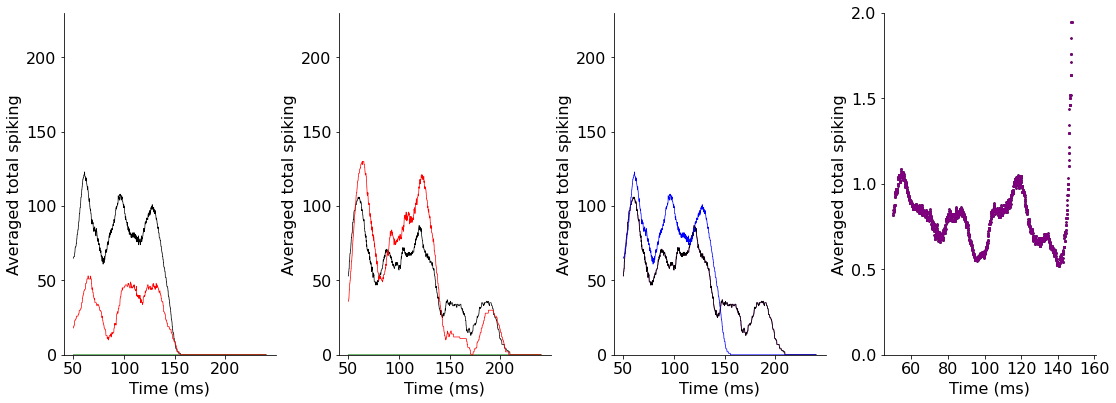

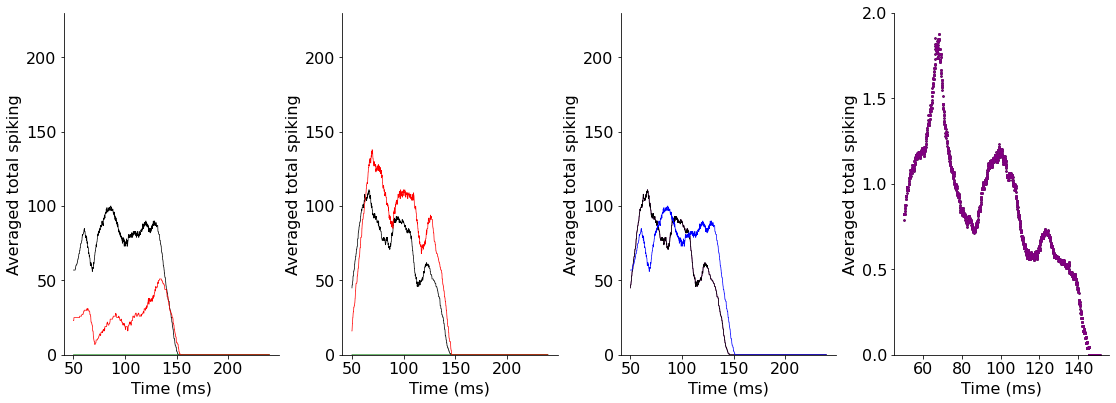

In [24]:
make_total_activity_graphs(['50_per_silent_no_syn'],
                           timepoints=[49, 170], n_exc=200, new_cell_idx=200)

In [35]:
def make_figure_2_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_excs[idx], name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights_e_e'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights_e_e'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights_e_e']
                    baseline_std = data['std_incoming_summed_weights_e_e']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
            
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
#             axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color=condition_colors[idx][0], lw=0.5, zorder=-1)
#             axs[1].plot(timepoints[:len(all_mean_incoming_summed_weights_e_i)] * 10, all_mean_incoming_summed_weights_e_i, color=condition_colors[idx][1], lw=0.5, zorder=-1)

        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx
        trimmed_timepoints = timepoints[:len(e_e_means)]

        axs[0].fill_between(
            trimmed_timepoints * 10,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(trimmed_timepoints * 10, e_e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            trimmed_timepoints * 10,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(trimmed_timepoints * 10, e_i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(10 * timepoints[0], 10 * timepoints[-1])
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 14)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

['50_per_silent_no_syn']
50_per_silent_no_syn_2022-06-15--17:35--55:5107
50_per_silent_no_syn_2022-06-15--17:36--14:2567


No handles with labels found to put in legend.


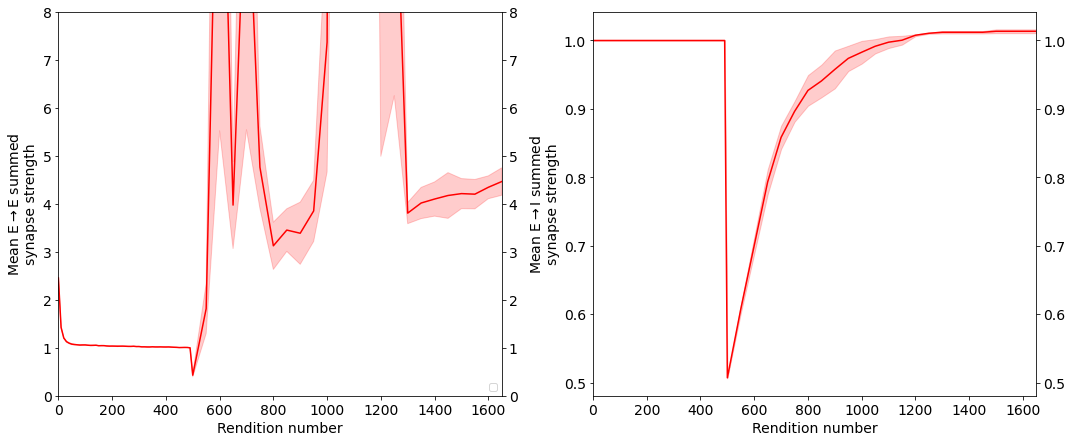

In [36]:
make_figure_2_plot([
    ['50_per_silent_no_syn'],
], labels=[''] * 20, condition_colors=[
    ('red', 'red'),
],
timepoints=np.concatenate([np.arange(0, 50), np.arange(50, 170, 5)]), offsets=49 * np.ones(20),
n_excs=[200, 200, 200], ylim1=(0, 8))

In [81]:
def make_weight_entropy_plot(names, labels, condition_colors, n_excs=[450], file_name_ext='', ylim1=None, ylim2=None,
                       ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=0.,
                       axs=None, fig=None, tick_right=True, legend=True):
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weight_entropies_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            
            if j >= 10:
                continue
            
            all_weight_entropies = []

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_excs[idx], name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                w_r_e_e = data['w_r_e'][:n_excs[idx], :n_excs[idx]]
                if 'surviving_cell_mask'in data:
                    surviving_cell_mask = data['surviving_cell_mask']
                    w_r_e_e = w_r_e_e[surviving_cell_mask, :]
                normed_w_r_e_e = np.array(w_r_e_e.todense()) / w_r_e_e.sum(axis=1)
                normed_w_r_e_e = normed_w_r_e_e[np.logical_and(~np.isnan(normed_w_r_e_e), normed_w_r_e_e > 0)]
                log_w_r_e_e = np.log(normed_w_r_e_e)
                
                weight_entropy = -1 * np.nanmean([np.dot(normed_w_r_e_e[m,:], log_w_r_e_e[m,:].T) for m in range(normed_w_r_e_e.shape[0])])
                                   
                all_weight_entropies.append(weight_entropy)
            
            all_weight_entropies_for_dir_name.append(all_weight_entropies)
            
        if len(all_weight_entropies_for_dir_name) == 0:
            continue
        
        means = safe_apply_stat(all_weight_entropies_for_dir_name, np.mean)
        sems = safe_apply_stat(all_weight_entropies_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx

        axs[0].fill_between(
            timepoints * 10,
            means - sems + y_disp,
            means + sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(timepoints * 10, means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E weight entropy')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlim(10 * timepoints[0], 10 * timepoints[-1])
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
            set_font_size(axs[i], 14)
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

['stdp_rand_syn', 'all']
['stdp_rand_syn', 'no_repl_20']
['stdp_rand_syn', 'no_repl_no_syn']
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2012_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0713
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2005_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:1805
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2007_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6435
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2013_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6753
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2016_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:8966
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2011_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:9272
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2017_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0209
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2018_W

stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2008_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:2681
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2003_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:4922
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2018_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:8822
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2001_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:1671
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2013_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:6753
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2019_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:9033
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2004_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_no_repl_no_syn_2022-05-09--22:42--20:5876
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2015_W_I_E_6e-05_W_E_I

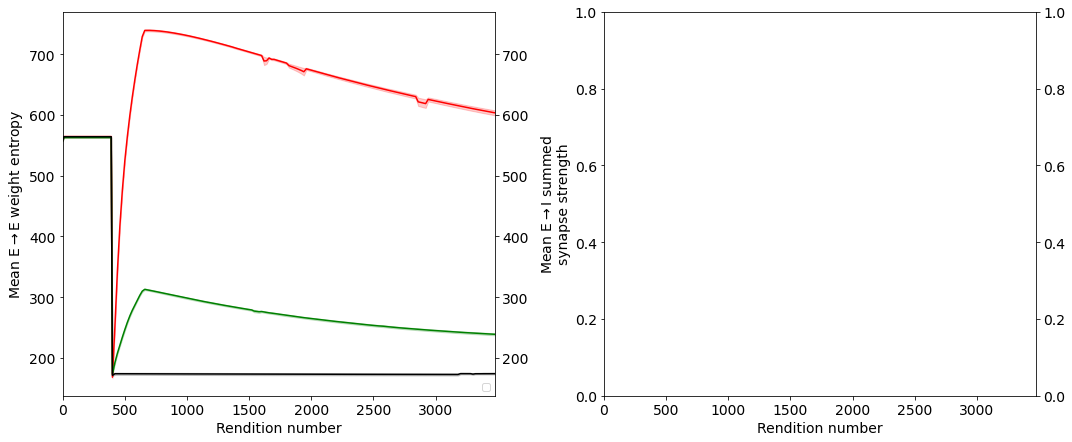

In [84]:
make_weight_entropy_plot([
    ['stdp_rand_syn', 'all'],
    ['stdp_rand_syn', 'no_repl_20'],
    ['stdp_rand_syn', 'no_repl_no_syn'],
], labels=[''] * 20, condition_colors=[
    ('red', 'red'),
    ('green', 'green'),
    ('black', 'black'),
],
timepoints=np.concatenate([np.arange(40), np.arange(40, 350, 2)]), offsets=39 * np.ones(20), n_excs=[450, 300, 300])

In [16]:
def make_timing_precision_graphs(names, timepoints=[600], n_exc=900):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            scale = 1.1

            fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
            gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
            axs = [fig.add_subplot(gs[:, 0])]

            j = 0

            all_first_spk_times = []

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
                if j < len(timepoints) and i == timepoints[j]:
                    data = load_data()
                    first_spk_times = data['first_spk_times']
                    original_surviving_mask = np.arange(n_exc) < n_exc       
                    if 'surviving_cell_mask' in data:
                        original_surviving_mask = np.logical_and(original_surviving_mask, data['surviving_cell_mask']).astype(bool)
                        
                    first_spk_times = data['first_spk_times'][original_surviving_mask]
                    all_first_spk_times.append(first_spk_times)
                    j += 1
            
            all_first_spk_times = np.stack(all_first_spk_times)
            all_nan_means = np.nanmean(all_first_spk_times, axis=0)
            all_nan_stds = np.nanstd(all_first_spk_times, axis=0)

            axs[0].scatter(all_nan_means, all_nan_stds, s=3., c='black', zorder=0, alpha=1)

            set_font_size(axs[0], 16)
            axs[0].spines['right'].set_visible(False)
            axs[0].spines['top'].set_visible(False)
            
            axs[0].set_xlabel('Firing time (s)')
            axs[0].set_ylabel('First spike STD (s)')
            
            axs[0].set_ylim(0, 0.005)

stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2012_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0713
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2005_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:1805
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2007_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6435
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2013_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6753
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2016_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:8966
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2011_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:9272
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2017_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0209
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2018_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:8822
stdp_rand_syn_sl

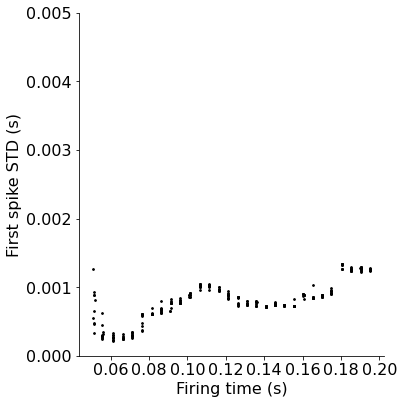

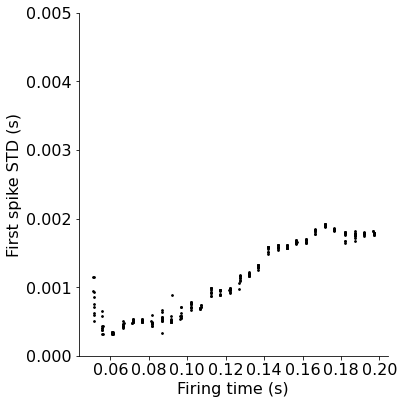

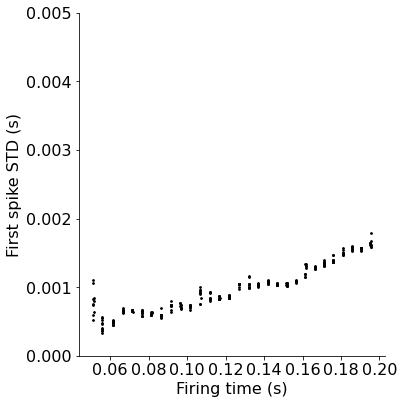

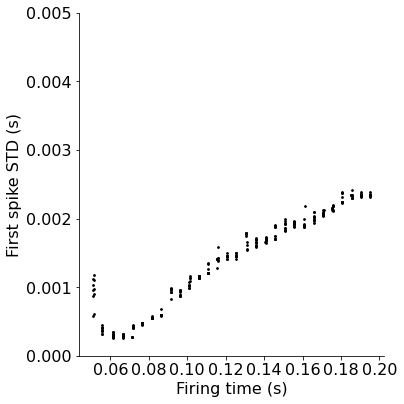

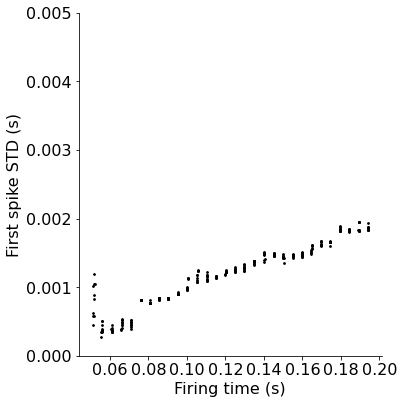

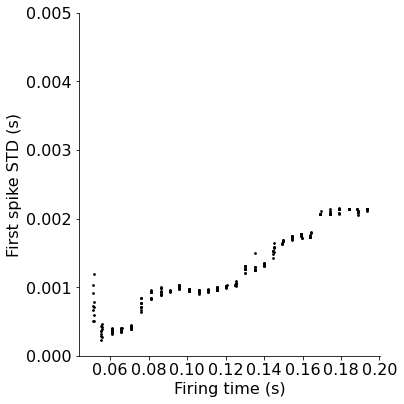

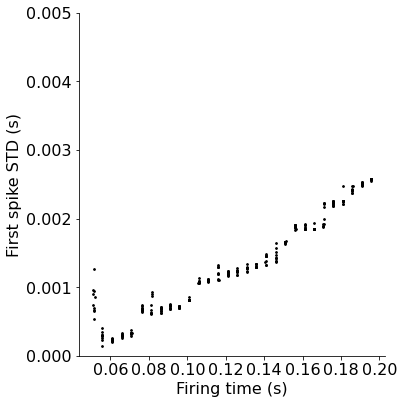

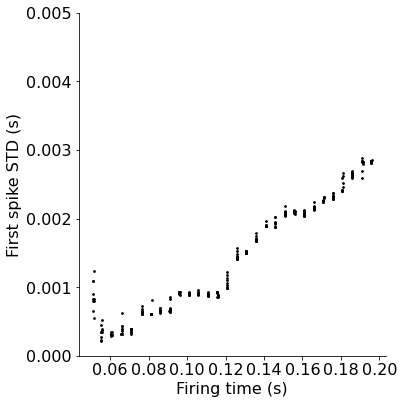

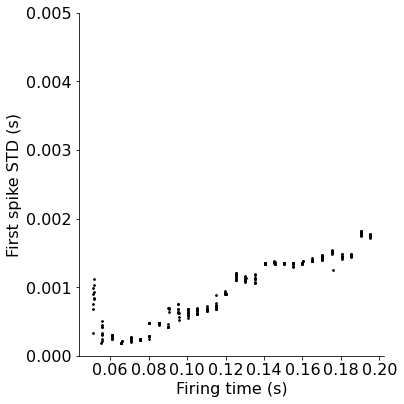

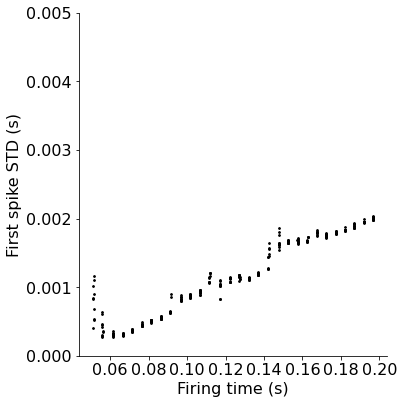

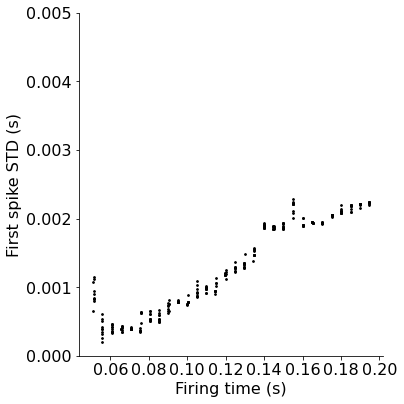

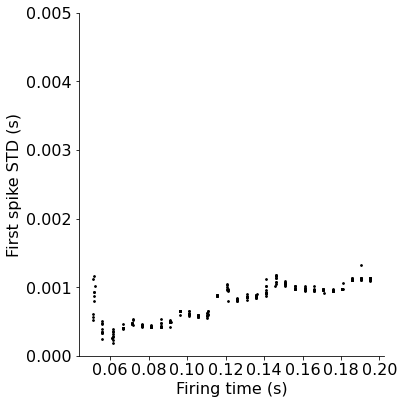

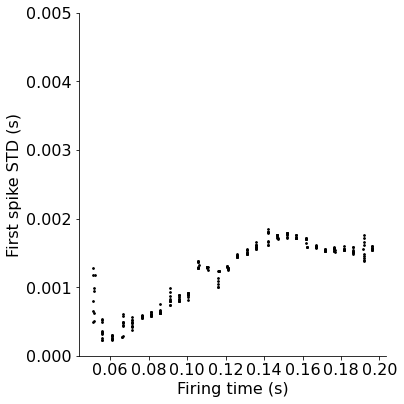

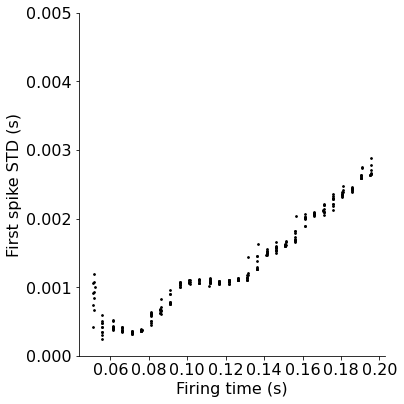

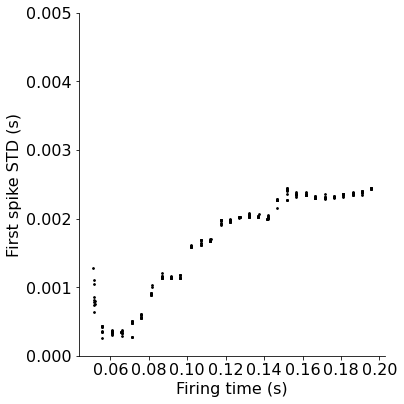

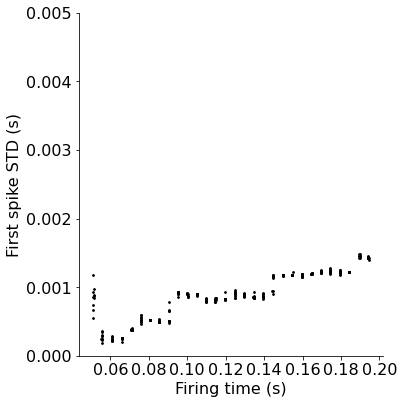

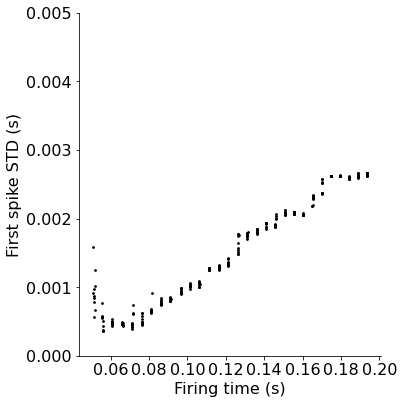

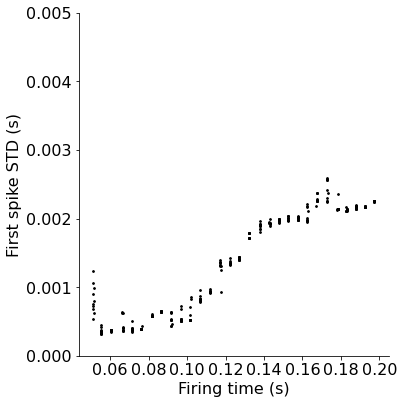

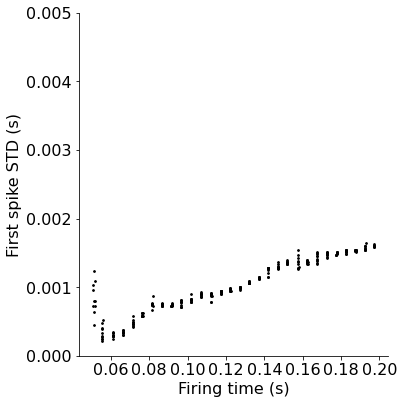

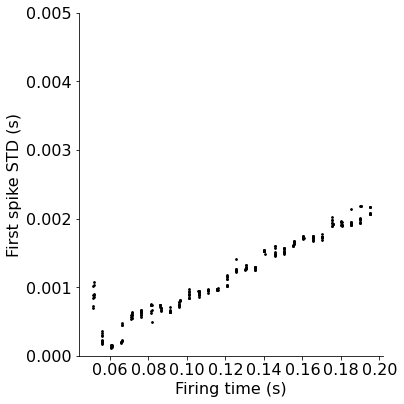

In [17]:
make_timing_precision_graphs([
     ['stdp_rand_syn', 'all'],
],  np.arange(30, 39), n_exc=300)

stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2012_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0713
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2005_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:1805
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2007_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6435
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2013_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:6753
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2016_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:8966
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2011_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:9272
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2017_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:0209
stdp_rand_syn_slow_8__DROP_SEV_0.5_SEED_2018_W_I_E_6e-05_W_E_I_7e-05_W_E_E_0.0012_CONDITION_all_2022-05-09--22:42--20:8822
stdp_rand_syn_sl

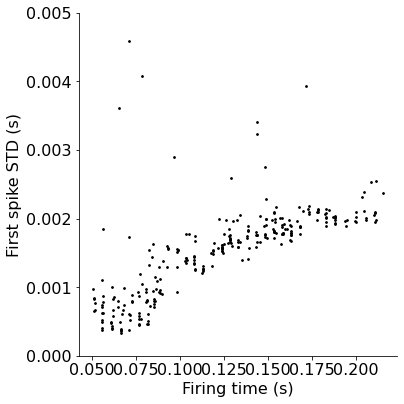

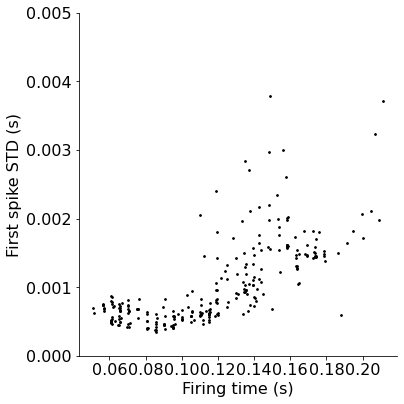

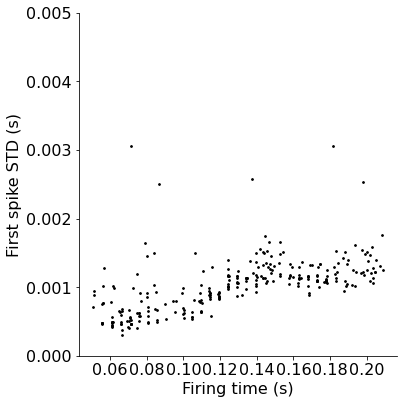

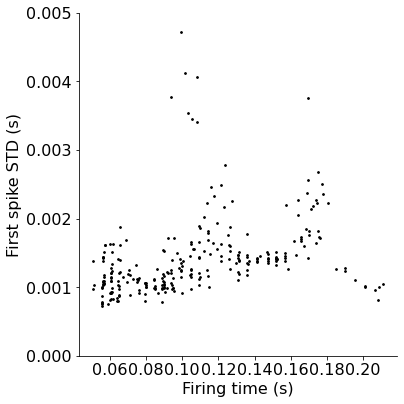

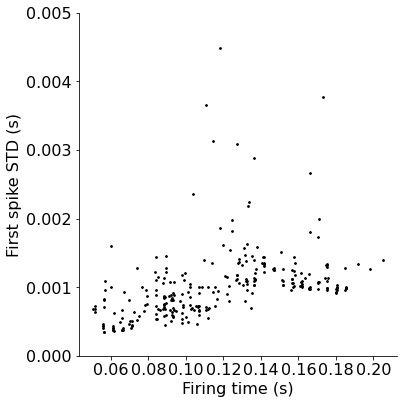

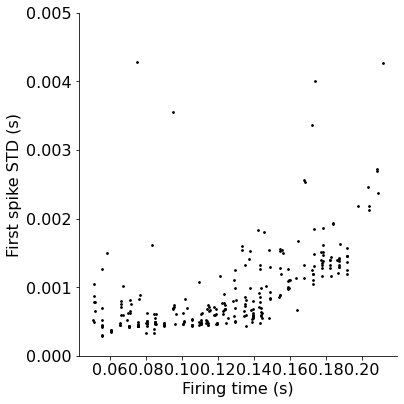

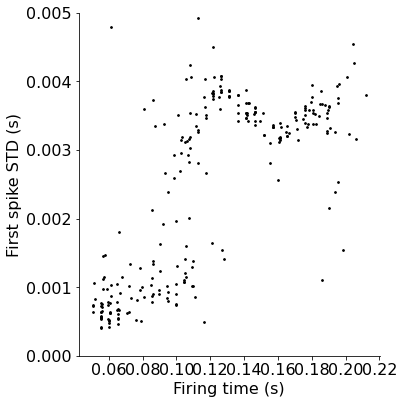

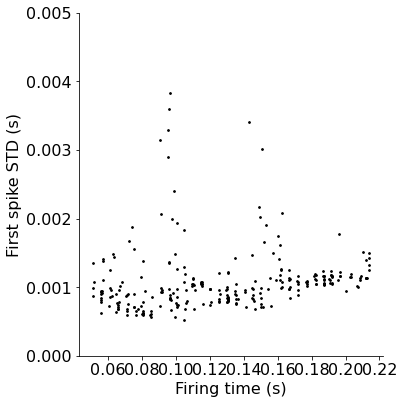

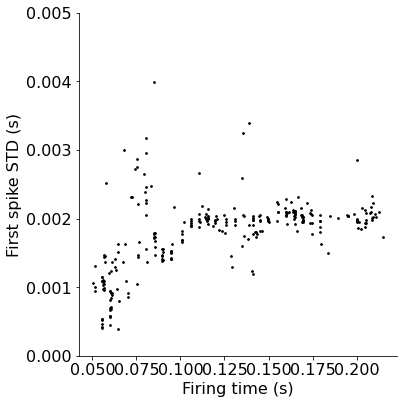

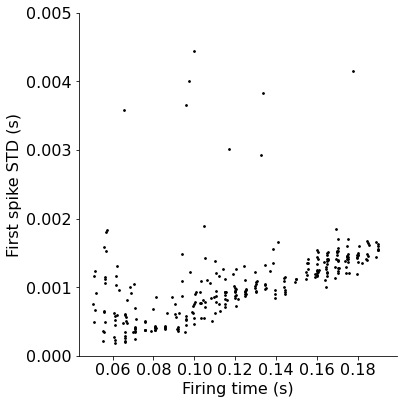

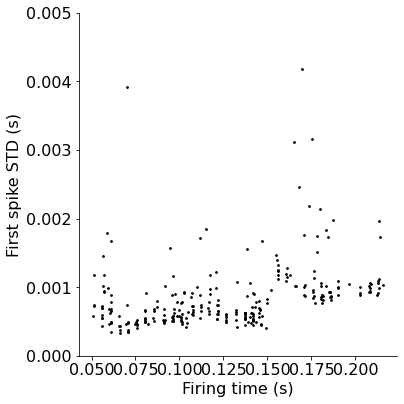

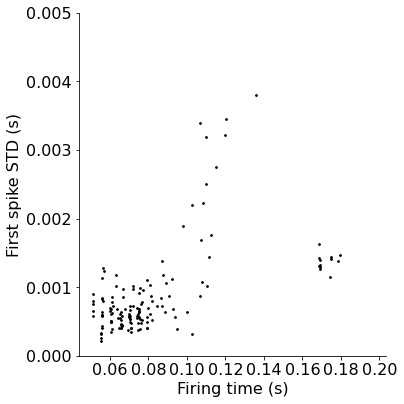

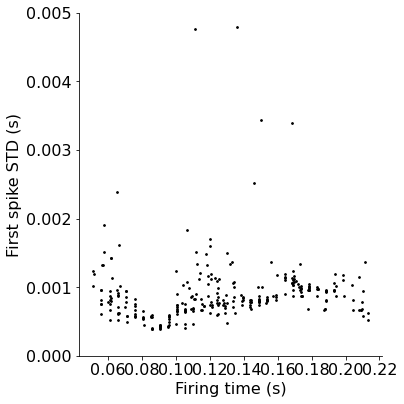

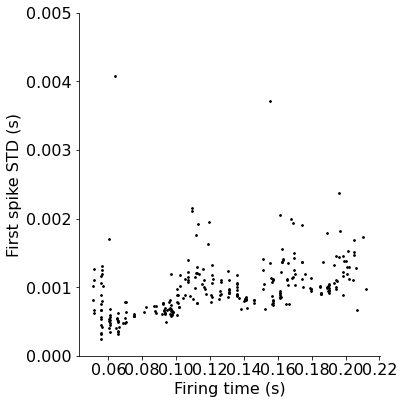

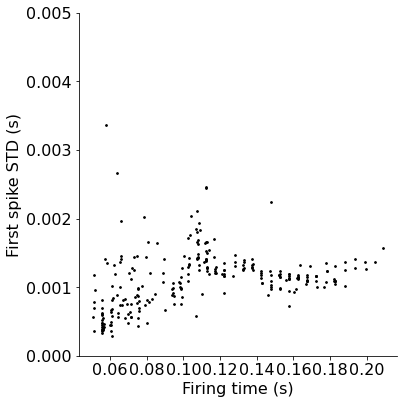

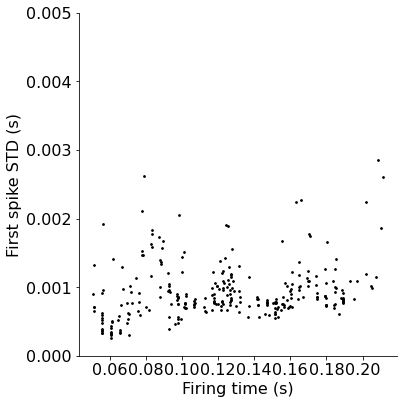

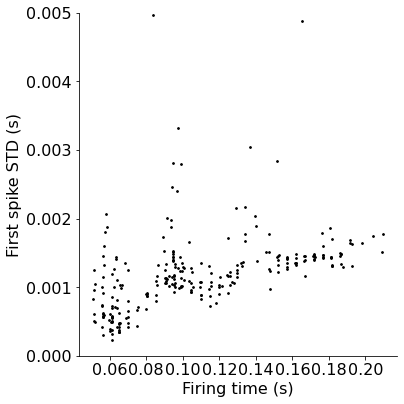

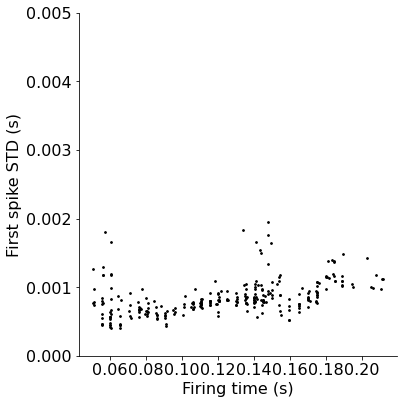

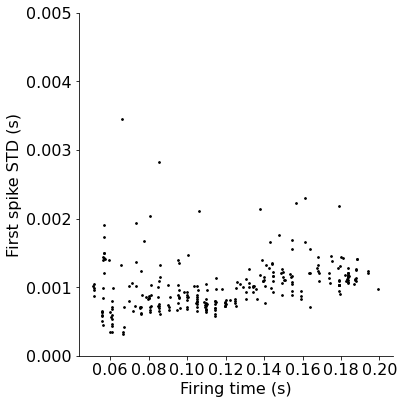

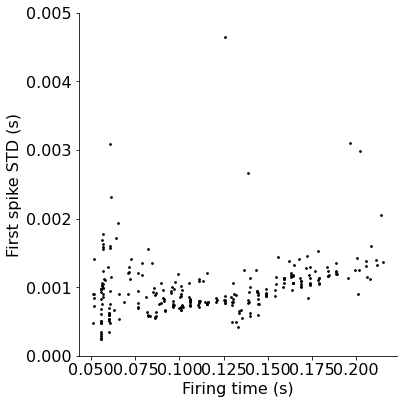

In [18]:
make_timing_precision_graphs([
     ['stdp_rand_syn', 'all'],
],  np.arange(340, 349), n_exc=450)

In [ ]:
def make_timing_precision_graphs(names, timepoints=[600], n_exc=900):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    for i, exp_dir_names in enumerate(all_dirs):   
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            scale = 1.1

            fig = plt.figure(constrained_layout=True, figsize=(5 * scale, 5 * scale))
            gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
            axs = [fig.add_subplot(gs[:, 0])]

            j = 0

            all_first_spk_times = []

            for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), n_exc=n_exc):
                if j < len(timepoints) and i == timepoints[j]:
                    data = load_data()
                    first_spk_times = data['first_spk_times']
                    original_surviving_mask = np.arange(n_exc) < n_exc       
                    if 'surviving_cell_mask' in data:
                        original_surviving_mask = np.logical_and(original_surviving_mask, data['surviving_cell_mask']).astype(bool)
                        
                    first_spk_times = data['first_spk_times'][original_surviving_mask]
                    all_first_spk_times.append(first_spk_times)
                    j += 1
            
            all_first_spk_times = np.stack(all_first_spk_times)
            all_nan_means = np.nanmean(all_first_spk_times, axis=0)
            all_nan_stds = np.nanstd(all_first_spk_times, axis=0)

            axs[0].scatter(all_nan_means, all_nan_stds, s=3., c='black', zorder=0, alpha=1)

            set_font_size(axs[0], 16)
            axs[0].spines['right'].set_visible(False)
            axs[0].spines['top'].set_visible(False)
            
            axs[0].set_xlabel('Firing time (s)')
            axs[0].set_ylabel('First spike STD (s)')
            
            axs[0].set_ylim(0, 0.005)